In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os as os
import sys as sys
import glob as glob
import re as re
import numpy as np
import shutil as shutil

import paprika
print(paprika.__version__)

from paprika.analysis import fe_calc
from paprika.restraints import DAT_restraint

import pytraj as pt
import parmed as pmd

2018-04-30_14:45:29_-0700-dff30ec-0.0.3


In [23]:
import logging
from importlib import reload
reload(logging)

logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.INFO)
logging.info('Started logging...')

2018-04-30 03:49:39 PM Started logging...


In [24]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']
guest_anchors = [':2@C1', ':2@C3']

In [25]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

windows = [len(attach_fractions), len(pull_string.split()), 0]

paths = glob.glob(os.path.normpath(os.path.join('./OA-G3-0', 'AMBER', 'APR', 'windows', '*')))

window_list = [os.path.basename(i) for i in paths]
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

In [26]:
fractions = np.arange(0.01, 1.01, 0.01)
data = np.zeros((len(g3_complexes), len(fractions), 6))

In [31]:
for complex_index, complx in enumerate(sorted(g3_complexes)):

    print(complx)
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]

    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)

    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')   
    
    
    for fraction_index, fraction in enumerate(fractions):

        fecalc = fe_calc()
        fecalc.prmtop = stripped.topology
        fecalc.trajectory = 'prod.*.nc'
        fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
        fecalc.restraint_list = guest_restraints
        fecalc.collect_data(fraction=fraction)
        fecalc.compute_free_energy()

        data[complex_index, fraction_index, 0] = complex_index
        data[complex_index, fraction_index, 1] = fecalc.results['attach']['mbar-block']['fe']
        data[complex_index, fraction_index, 2] = fecalc.results['attach']['mbar-block']['sem']
        data[complex_index, fraction_index, 3] = fecalc.results['pull']['mbar-block']['fe']
        data[complex_index, fraction_index, 4] = fecalc.results['pull']['mbar-block']['sem']

        # Analytic release

        fecalc.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, 
                                        None, guest_restraints[2], None])

        data[complex_index, fraction_index, 5] = fecalc.results['ref_state_work']

        print(f"{fecalc.results['attach']['mbar-block']['fe']:03f} ± {fecalc.results['attach']['mbar-block']['sem']:03f}")
        print(f"{fecalc.results['pull']['mbar-block']['fe']:03f} ± {fecalc.results['pull']['mbar-block']['sem']:03f}")
    

./OA-G3-0


2018-04-30 03:53:08 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:09 PM pull: computing convergence for mbar-blocking


4.455687 ± 0.147483
9.660774 ± 1.009513


2018-04-30 03:53:10 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:11 PM pull: computing convergence for mbar-blocking


1.078108 ± 0.056718
8.890181 ± 0.749816


2018-04-30 03:53:12 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:14 PM pull: computing convergence for mbar-blocking


1.000961 ± 0.050619
8.947201 ± 0.660412


2018-04-30 03:53:15 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:18 PM pull: computing convergence for mbar-blocking


0.989156 ± 0.039006
8.764143 ± 0.535815


2018-04-30 03:53:19 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:22 PM pull: computing convergence for mbar-blocking


1.011640 ± 0.039165
9.287347 ± 0.504349


2018-04-30 03:53:23 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:26 PM pull: computing convergence for mbar-blocking


0.996274 ± 0.031868
9.391542 ± 0.432572


2018-04-30 03:53:28 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:31 PM pull: computing convergence for mbar-blocking


1.002974 ± 0.029604
9.562951 ± 0.444228


2018-04-30 03:53:33 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:37 PM pull: computing convergence for mbar-blocking


0.990292 ± 0.029314
9.670572 ± 0.406726


2018-04-30 03:53:39 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:44 PM pull: computing convergence for mbar-blocking


0.978349 ± 0.028356
9.632611 ± 0.376264


2018-04-30 03:53:46 PM attach: computing convergence for mbar-blocking
2018-04-30 03:53:52 PM pull: computing convergence for mbar-blocking


0.977997 ± 0.026767
9.578664 ± 0.344820


2018-04-30 03:53:54 PM attach: computing convergence for mbar-blocking
2018-04-30 03:54:01 PM pull: computing convergence for mbar-blocking


1.002146 ± 0.027559
9.566056 ± 0.357968


2018-04-30 03:54:03 PM attach: computing convergence for mbar-blocking
2018-04-30 03:54:10 PM pull: computing convergence for mbar-blocking


1.016792 ± 0.031137
9.488702 ± 0.334690


2018-04-30 03:54:12 PM attach: computing convergence for mbar-blocking
2018-04-30 03:54:20 PM pull: computing convergence for mbar-blocking


1.018794 ± 0.024645
9.476483 ± 0.329093


2018-04-30 03:54:23 PM attach: computing convergence for mbar-blocking
2018-04-30 03:54:32 PM pull: computing convergence for mbar-blocking


1.018715 ± 0.024023
9.564818 ± 0.317458


2018-04-30 03:54:34 PM attach: computing convergence for mbar-blocking
2018-04-30 03:54:43 PM pull: computing convergence for mbar-blocking


1.022242 ± 0.028243
9.475557 ± 0.314259


2018-04-30 03:54:45 PM attach: computing convergence for mbar-blocking


KeyboardInterrupt: 

In [32]:
import pytraj as pt

In [45]:
structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                   os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

stripped = structure.strip(':WAT,:Na+,:Cl-')   

traj = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'prod*.nc'),
              stripped.topology)

distances = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))

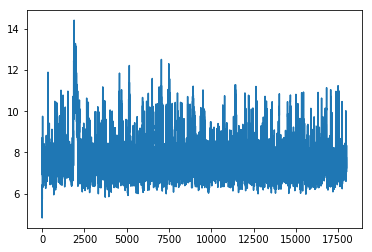

In [51]:
plt.plot(distances)

In [54]:
stripped.topology.save('vac.prmtop')

In [53]:
complx

'./OA-G3-0'